In [ ]:
!git clone https://github.com/WegraLee/deep-learning-from-scratch.git
%cd '/content/deep-learning-from-scratch'

fatal: destination path 'deep-learning-from-scratch' already exists and is not an empty directory.
/content/deep-learning-from-scratch


**[ILSVRC](https://www.image-net.org/challenges/LSVRC/)** : ImageNet Large Scale Visual Recognition Challenge
- ImageNet : 대규모 이미지 데이터셋
- 클래스 1000개 분류 문제
- top-5 error : 예측 확률 상위 5개의 클래스 내에 정답이 없는 비율
 - ResNet (150층 이상, 2015)의 top-5 error는 3.5%로, 실제 인간의 인식 능력을 초월하는 것으로 평가

# CNN

[ [ Conv $\rightarrow$ ReLU ] $\rightarrow$ [ Conv $\rightarrow$ ReLU $\rightarrow$ Pool ] ] (채널 : 16 / cv filter size : 3)  
$\longrightarrow$ [ [ Conv $\rightarrow$ ReLU ] $\rightarrow$ [ Conv $\rightarrow$ ReLU $\rightarrow$ Pool ] ] (채널 : 32 / cv filter size : 3)  
$\longrightarrow$ [ [ Conv $\rightarrow$ ReLU ] $\rightarrow$ [ Conv $\rightarrow$ ReLU $\rightarrow$ Pool ] ] (채널 : 64 / cv filter size : 3)  
$\longrightarrow$ [ [ Affine $\rightarrow$ ReLU $\rightarrow$ Dropout ] $\rightarrow$ [ Affine $\rightarrow$ Dropout ] ] $\longrightarrow$ [ Softmax ]

- weight init : He
- optimizer : Adam

In [ ]:
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *

class DeepConvNet:
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1},
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10):
        
        # He 초깃값
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        wight_init_scales = np.sqrt(2.0 / pre_node_nums)
        
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = wight_init_scales[idx] * np.random.randn(conv_param['filter_num'],
                                                                                     pre_channel_num,
                                                                                     conv_param['filter_size'],
                                                                                     conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num'] # 현재 필터 개수가 다음 단계에 대한 입력 채널 수
        self.params['W7'] = wight_init_scales[6] * np.random.randn(64*4*4, hidden_size)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = wight_init_scales[7] * np.random.randn(hidden_size, output_size)
        self.params['b8'] = np.zeros(output_size)

        # 계층 생성
        self.layers = []
        self.layers.append(Convolution(self.params['W1'], self.params['b1'], 
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W2'], self.params['b2'], 
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W3'], self.params['b3'], 
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Affine(self.params['W7'], self.params['b7']))
        self.layers.append(Relu())
        self.layers.append(Dropout(0.5))
        self.layers.append(Affine(self.params['W8'], self.params['b8']))
        self.layers.append(Dropout(0.5))
        
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]

In [ ]:
# 훈련
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from ch08.deep_convnet import DeepConvNet
from common.trainer import Trainer
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# network = DeepConvNet()  
# trainer = Trainer(network, x_train, t_train, x_test, t_test,
#                   epochs=20, mini_batch_size=100,
#                   optimizer='Adam', optimizer_param={'lr':0.001},
#                   evaluate_sample_num_per_epoch=1000)
# trainer.train()

# # 매개변수 보관
# network.save_params("deep_convnet_params.pkl")
# print("Saved Network Parameters!")

# 사전에 학습된 매개변수 불러오기
dcn = DeepConvNet()
dcn.load_params("ch08/deep_convnet_params.pkl")

In [ ]:
# test 세트(10000개)에 대한 정확도 출력
dcn.accuracy(x_test, t_test)
# 65개 오분류

0.9935

test accuracy : 0.9935


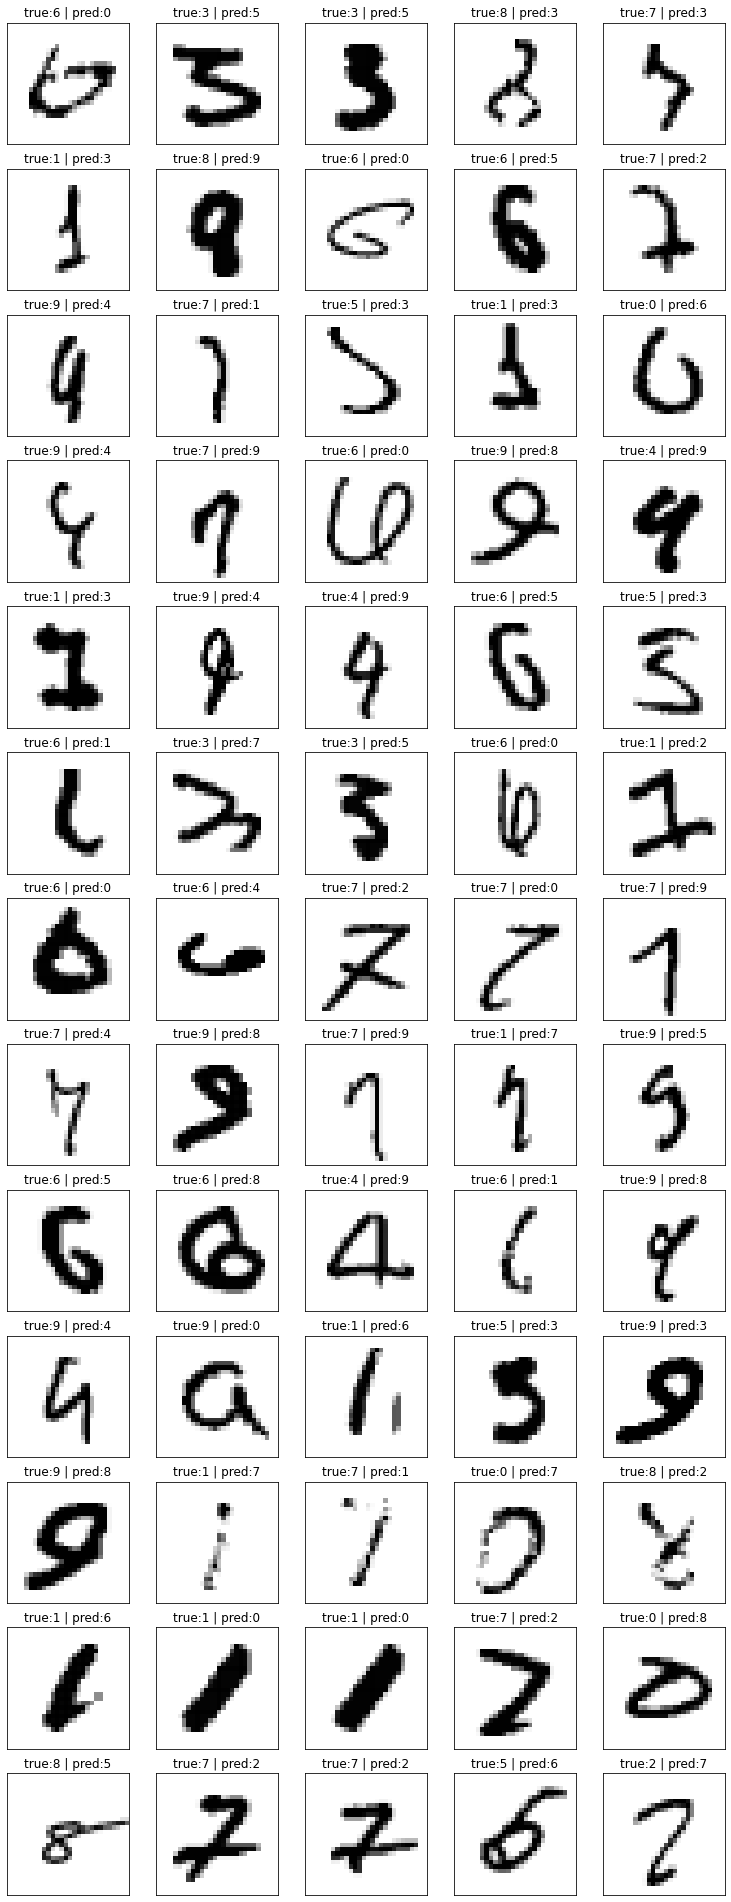

In [ ]:
# 미니배치 단위로 예측
classified_ids = []
acc = 0.0
batch_size = 100

for i in range(int(x_test.shape[0] / batch_size)):
    tx = x_test[i*batch_size:(i+1)*batch_size]
    tt = t_test[i*batch_size:(i+1)*batch_size]
    y = dcn.predict(tx, train_flg=False)
    y = np.argmax(y, axis=1) # 현재 미니배치에 대한 예측 분류 클래스
    classified_ids.append(y)
    acc += np.sum(y==tt)
    
acc /= x_test.shape[0]
print("test accuracy :", acc)
classified_ids = np.array(classified_ids)
classified_ids = classified_ids.flatten()

# 오분류 시각화
current = 1
fig = plt.figure(figsize=(10,26))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)
for i, val in enumerate(classified_ids==t_test): # 각각의 분류 케이스에 대해,
    if not val: # 오분류인 경우,
        ax = fig.add_subplot(13, 5, current, xticks=[], yticks=[])
        ax.imshow(x_test[i].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
        ax.set_title(f'true:{t_test[i]} | pred:{classified_ids[i]}')
        
        current += 1
        if current>65:
            break
plt.show()
# 사실상 실제 사람도 분류하기 어려운 샘플이 많음

복잡한 task (object detection 등)의 신경망
- 깊은 층
  - 작은 cv filter size로 넓은 receptive field를 소화 + 활성화 함수의 비선형성 추가 $\rightarrow$ 적은 매개변수로 복잡한 표현 가능 (효율성)
  - cv filter별 역할 분담 $\rightarrow$ 하나의 복잡하고 추상적인 문제를 여러 가지 단순하고 구체적인 문제로 분해 $\rightarrow$ 데이터로부터 계층적인 정보를 학습 
- 앙상블
- 학습률 감소
- 데이터 확장
  - 회전, 이동, 자르기, 뒤집기, 밝기 조정, 확대, 축소 등 $\rightarrow$ 데이터셋 구축 부담 완화 + 모델 성능 개선

# [**VGGNet**](https://arxiv.org/pdf/1409.1556.pdf)

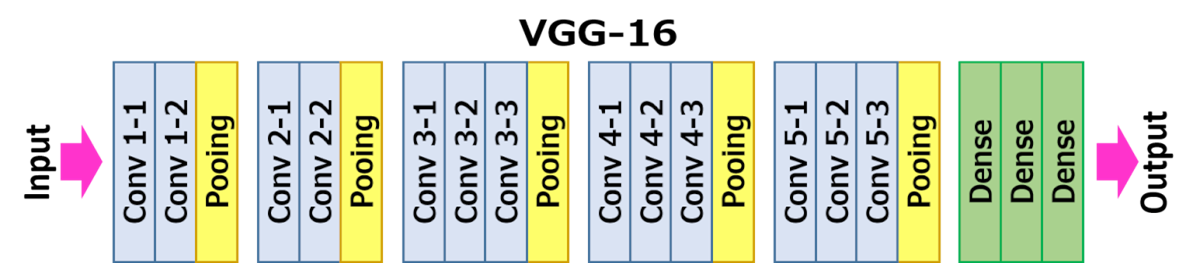

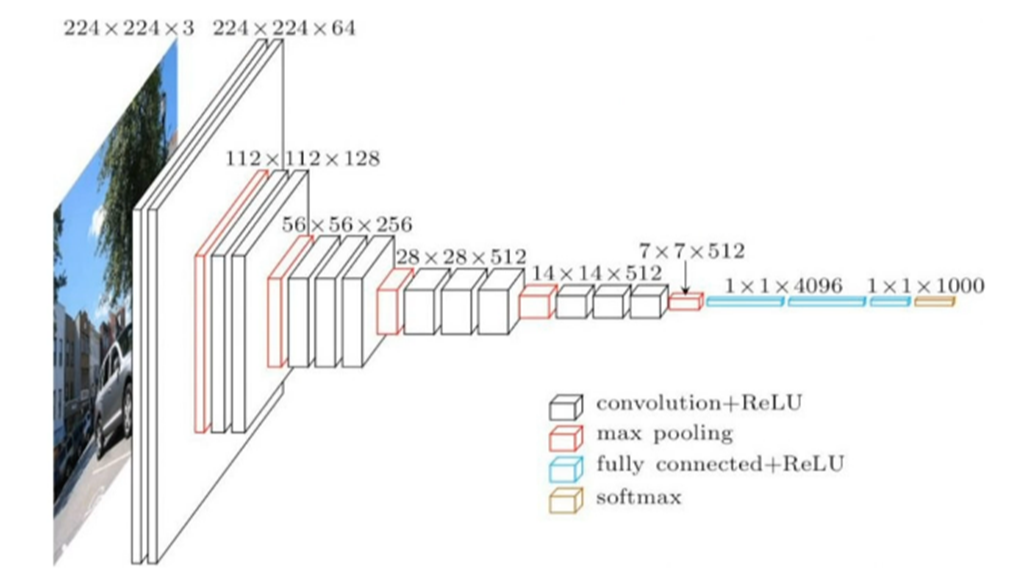

- 성능 : 2014년 2위
- 층의 깊이에 따라 VGG - 11, 13, 16, 19 등으로 구분
- kernel size가 3인 합성곱 계층을 연속적으로 구성 / 크기를 반감시키는 풀링 계층
- 비교적 간단한 구조 $\rightarrow$ 2014년 1위 GoogLeNet보다 높은 활용성

# [**GoogLeNet (=InceptionNet)**](https://arxiv.org/pdf/1409.4842.pdf)

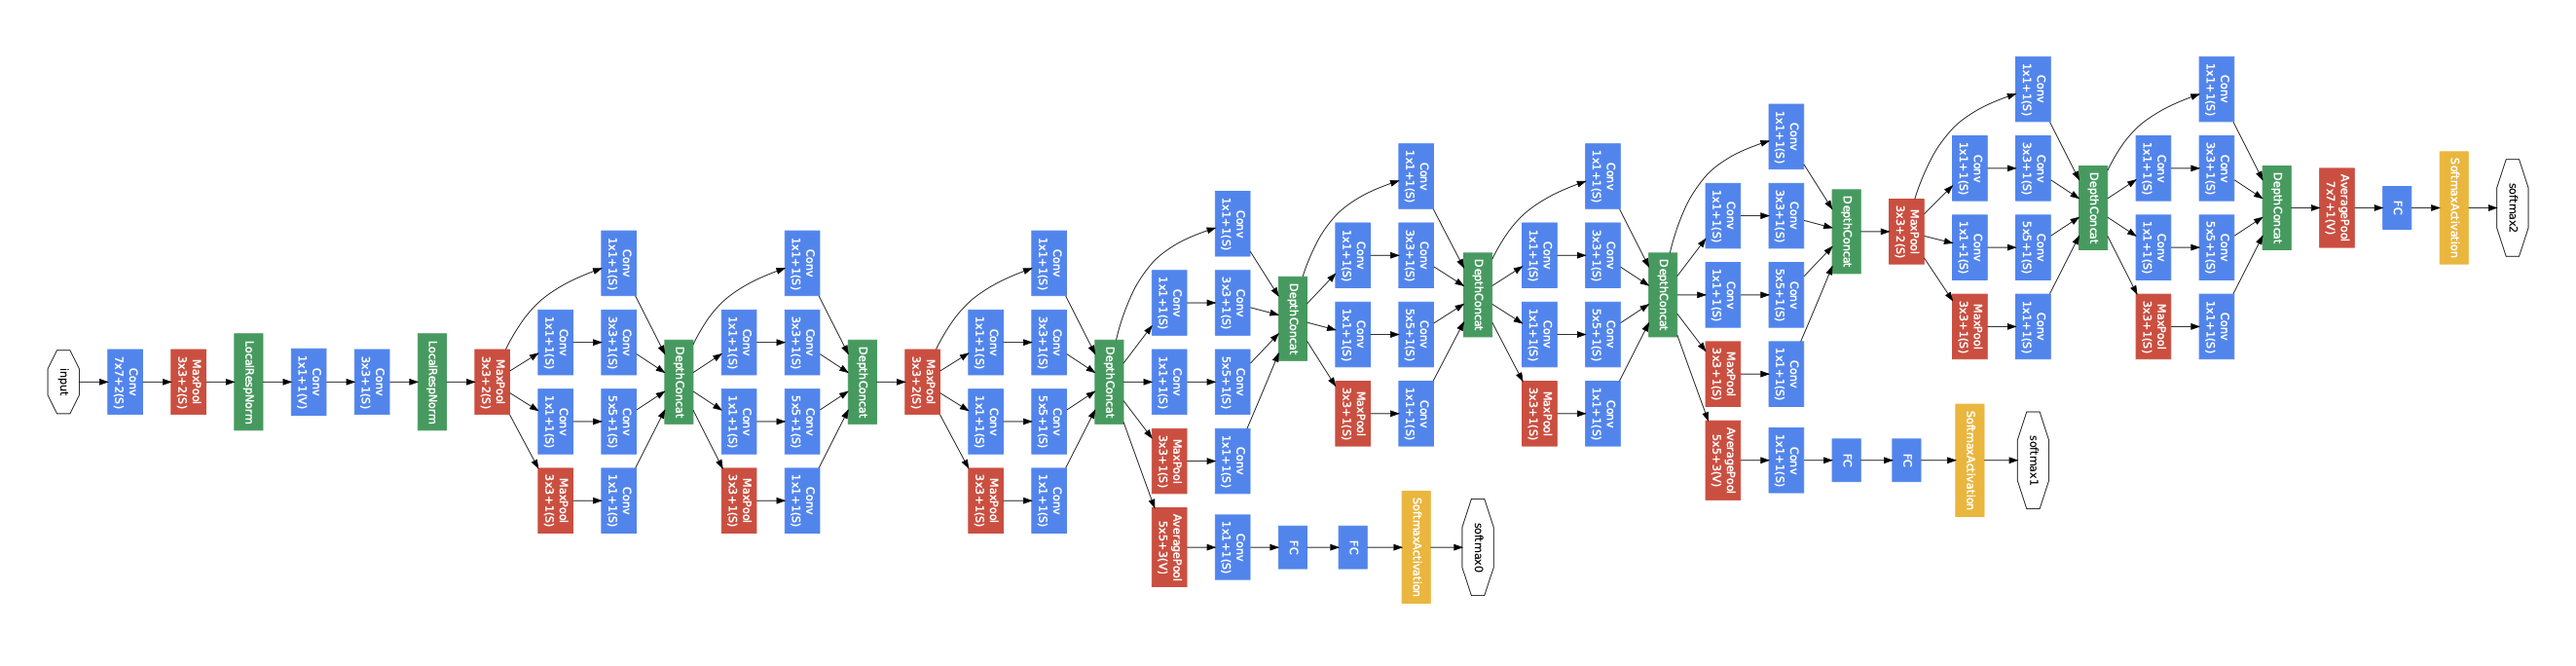

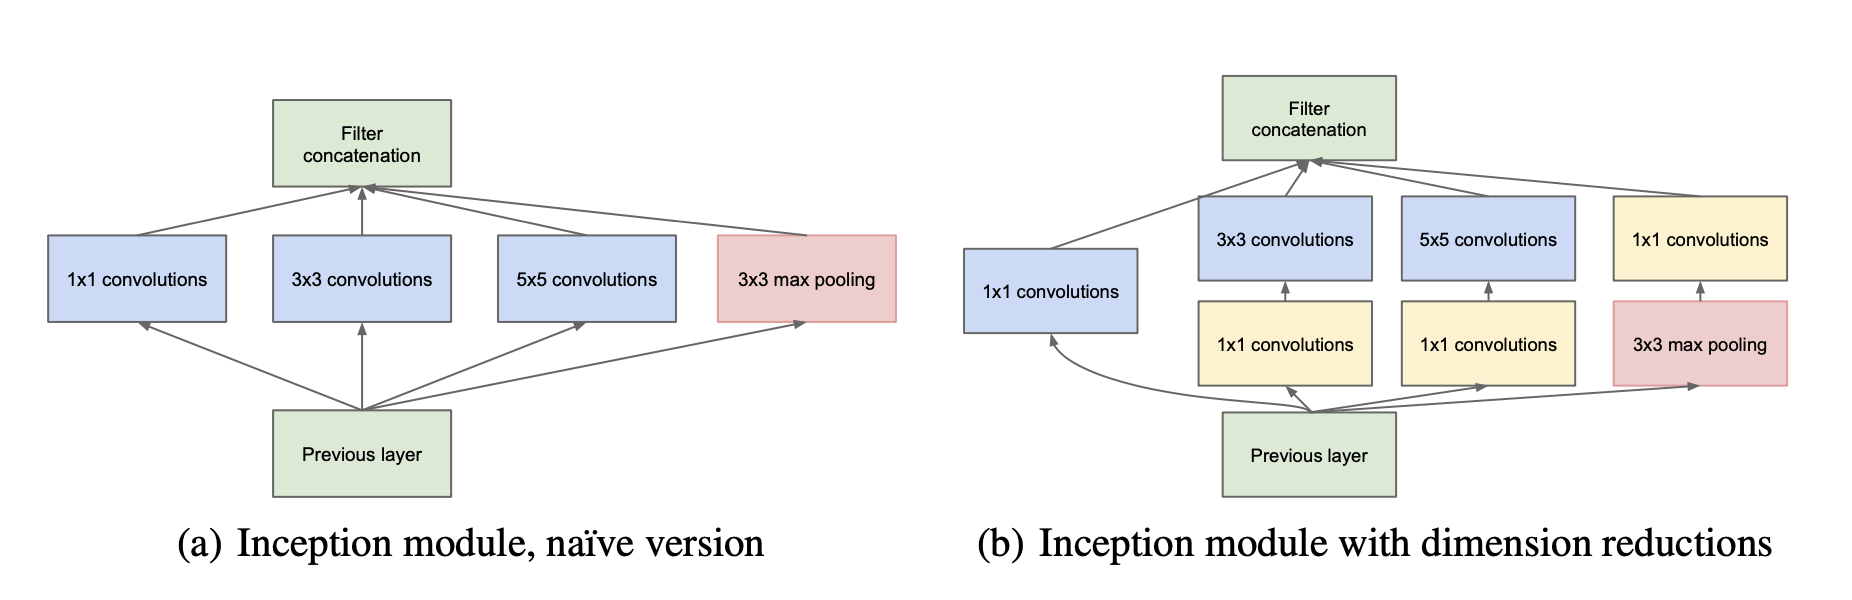

>**Inception module** : 각 층에서 한번에 더 다양한 정보를 추출하여 학습 속도를 개선하기 위해 제안된 구조
- 서로 다른 사이즈의 필터에 의한 출력의 사이즈를 통일하기 위해 padding을 적용하여 depth-wise concat 이후 전달
- (a) : 기본적인 Inception module 구조 $\rightarrow$ 매개변수 개수 증가 $\rightarrow$ 오버피팅
- (b) : kernel size가 1인 합성곱 계층을 통한 차원(채널) 축소 $\rightarrow$ bottleneck에서 Inception을 적용 $\rightarrow$ 매개변수 절약 및 오버피팅 방지

- 중간 층 부분에서 보조 분류기(auxiliary classifier)를 이용한 학습 $\rightarrow$ 깊은 층으로 인한 vanishing gradient problem 완화
>단, 추론 단계에서 보조 분류기는 무시  
$Loss=MainLoss+0.3\times Aux1Loss+0.3\times Aux2Loss$

# [**ResNet**](https://arxiv.org/pdf/1512.03385.pdf)

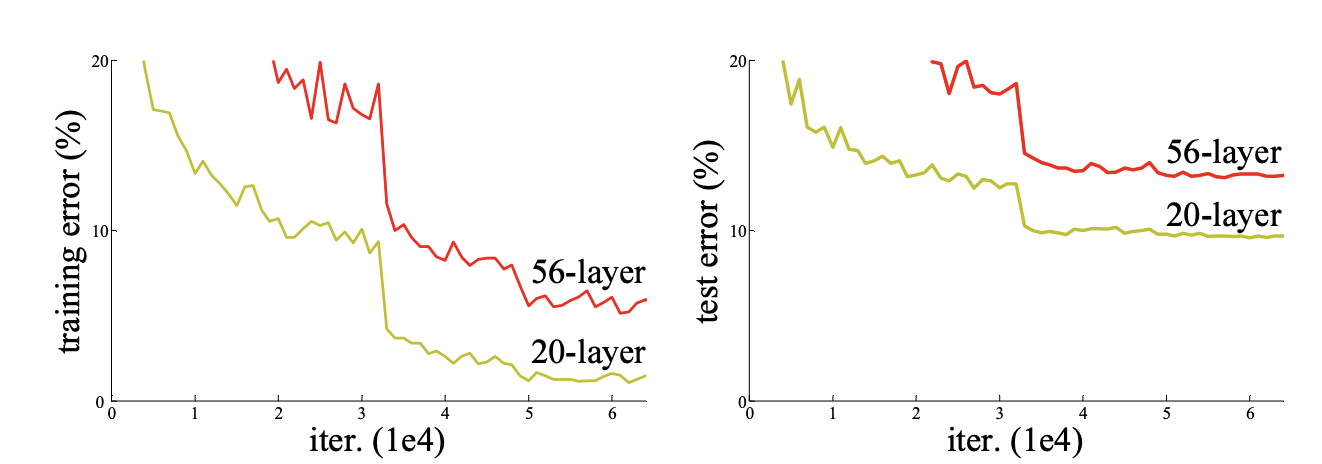

><ins>*Not overfitting, But degradation by vanishing gradient problem*</ins>

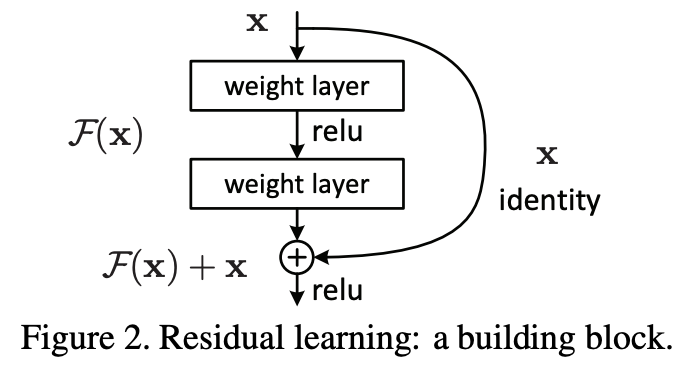

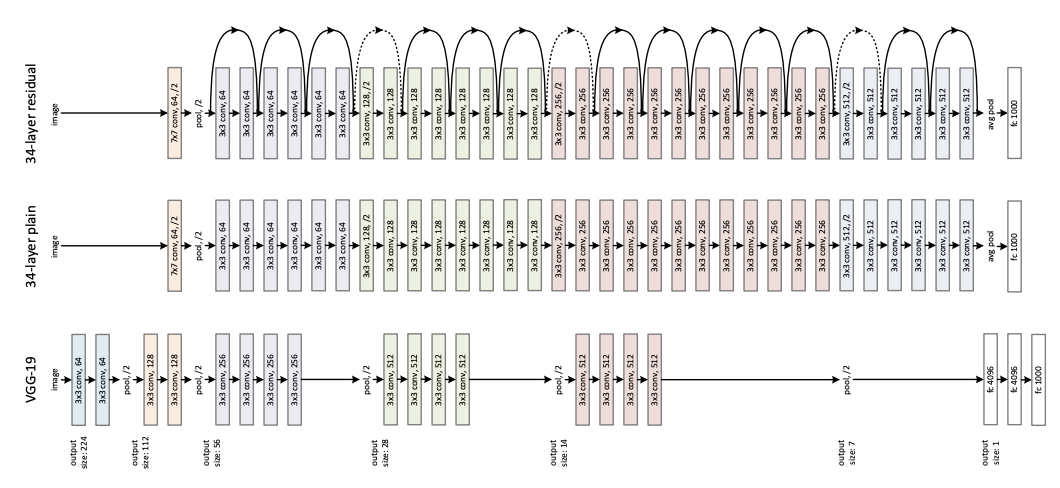

>**Skip connection** : vanishing gradient problem을 완화하면서 층을 깊게 하기 위한 구조 ; identity mapping
- 출력 $H(x)=F(x)+x$ 에 의해 정의되는 잔차 $F(x)=H(x)-x$ 를 최소화하는 목표 하에 학습
 - residual learning $\rightarrow$ vanishing gradient 방지
- bottleneck 구조 추가 $\rightarrow$ 오버피팅 방지
- 연구 & 해석
 1. optimal depth를 학습하는 것과 유사한 효과
 2. 많은 층에 걸쳐 고급 정보를 최대한 학습

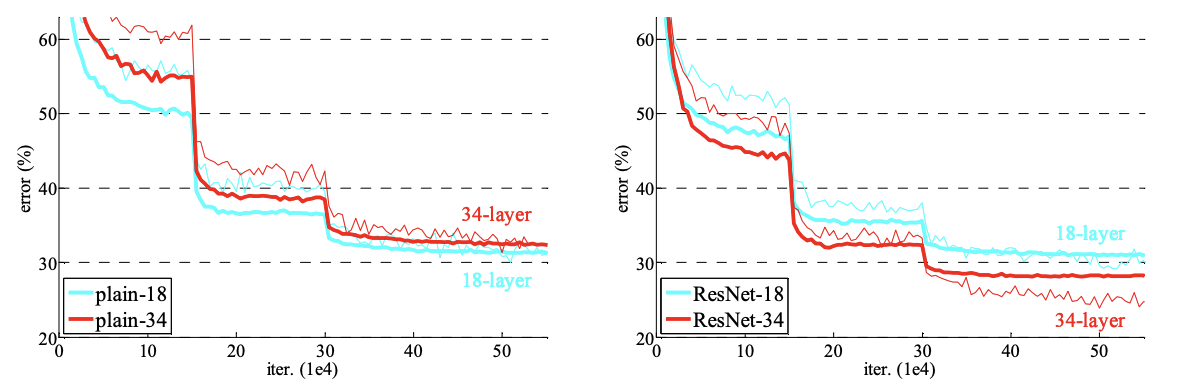

# Application to CV & NLP
<ins>multimodal processing</ins> = computer vision + natural language processing + ...

1. **Object Detection**
>R-CNN (Regions with CNN) / Faster R-CNN
 - SVM, Selective Search
2. **Segmentation**
>FCN (Fully Convolutional Network)
 - pixelwise prediction, bilinear interpolation, deconvolution
3. **Captioning**
>NIC (Neural Image Caption ; CNN + RNN) / RNN (Recurrent Neural Network)
4. [**Style Transfer**](https://arxiv.org/pdf/1508.06576.pdf)
 - Gram matrix
5. **Generation**
>GAN (Generative Adversarial Network ; Generator + Discriminator)
6. **Autonomous Driving**
>SegNet
 - Segmentation

# **Reinforcement Learning (RL)**
*action from expected reward*

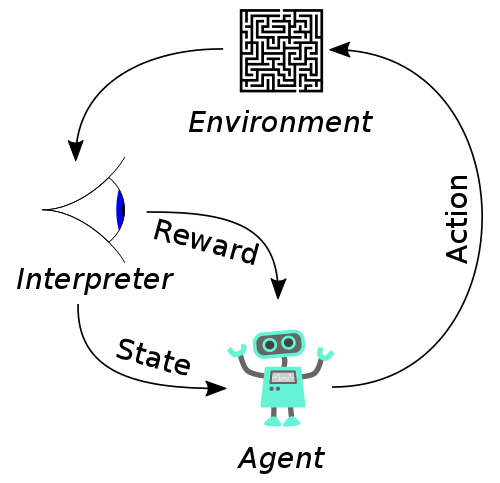

>DQN (Deep Q-Network ; CNN + Q-learning)
 - Q-learning : optimal action-value function determines how to act optimally
 - end-to-end $\rightarrow$ high applicability

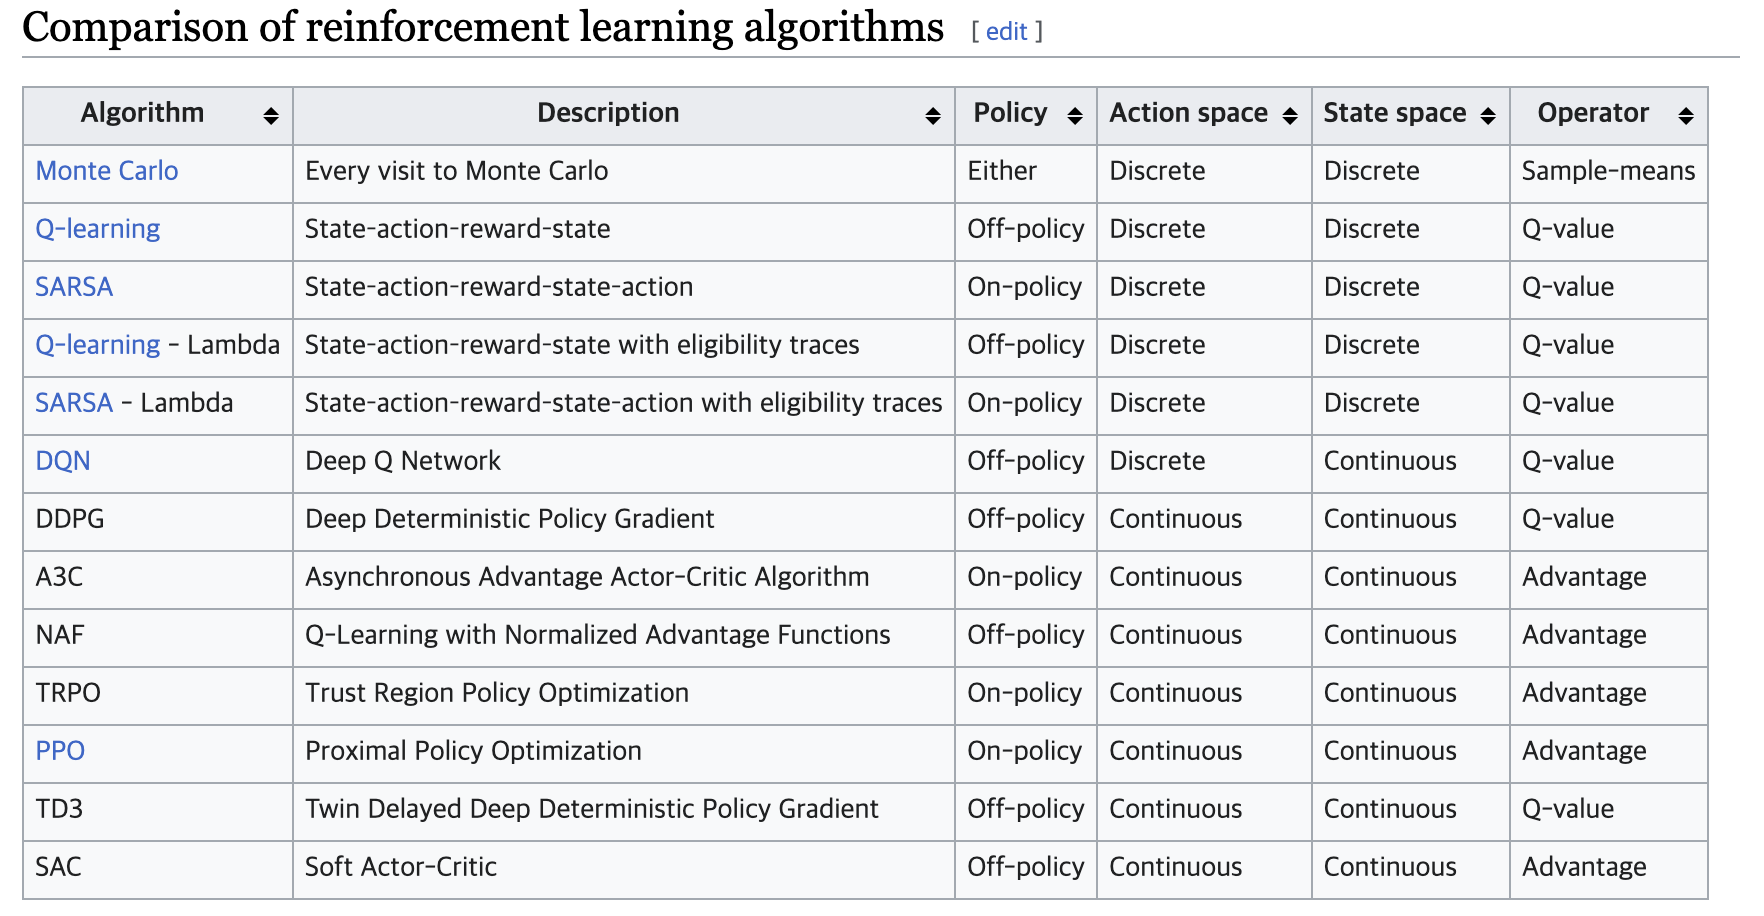